In [2]:
!python -m pip install autogluon

import pandas as pd
import numpy as np
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# import data
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

# # drop a unique feature
train_df = train_df.drop(columns=['Row ID'])

# # merge the train dataset with additional training data
extra_train_df = pd.read_csv('../Concrete_Data_Yeh.csv')
train_df = pd.concat([train_df, extra_train_df], ignore_index=True)

In [4]:
# adding new custom features
feature_columns = train_df.columns[:-1]

def add_new_features(train_df: pd.DataFrame, test_df: pd.DataFrame):
    # sum of admixtures, kg in m3
    admixtures = ['slag', 'flyash', 'coarseaggregate', 'fineaggregate', 'superplasticizer']
    # sum of admixtures_lowering_strength (all except superplasticizer that improves csMPa), kg in m3
    admixtures_lowering_strength = ['slag', 'flyash', 'coarseaggregate', 'fineaggregate']
    
    components_excl_water = [column for column in feature_columns if column not in ["water", "age"]]

    train_df['admixtures'] = train_df[admixtures].sum(axis=1) # kg in m3
    train_df['admixtures_lowering_strength'] = train_df[admixtures_lowering_strength].sum(axis=1) # кроме superplasticizer
    train_df['admixtures_lowering_strength_proportion'] = train_df[admixtures_lowering_strength].sum(axis=1) / (train_df['cement'] + train_df['superplasticizer'])
    # density = Mass (components without water, kg) / volume (m3)
    train_df['density'] = (train_df[components_excl_water].sum(axis=1) - train_df['water']) / 1000
    
    test_df['admixtures'] = test_df[admixtures].sum(axis=1) # kg in m3
    test_df['admixtures_lowering_strength'] = test_df[admixtures_lowering_strength].sum(axis=1) # кроме superplasticizer
    test_df['admixtures_lowering_strength_proportion'] = test_df[admixtures_lowering_strength].sum(axis=1) / (test_df['cement'] + test_df['superplasticizer'])
    test_df['density'] = (test_df[components_excl_water].sum(axis=1) - test_df['water']) / 1000
    
    return (train_df, test_df)

train_df, test_df = add_new_features(train_df, test_df)

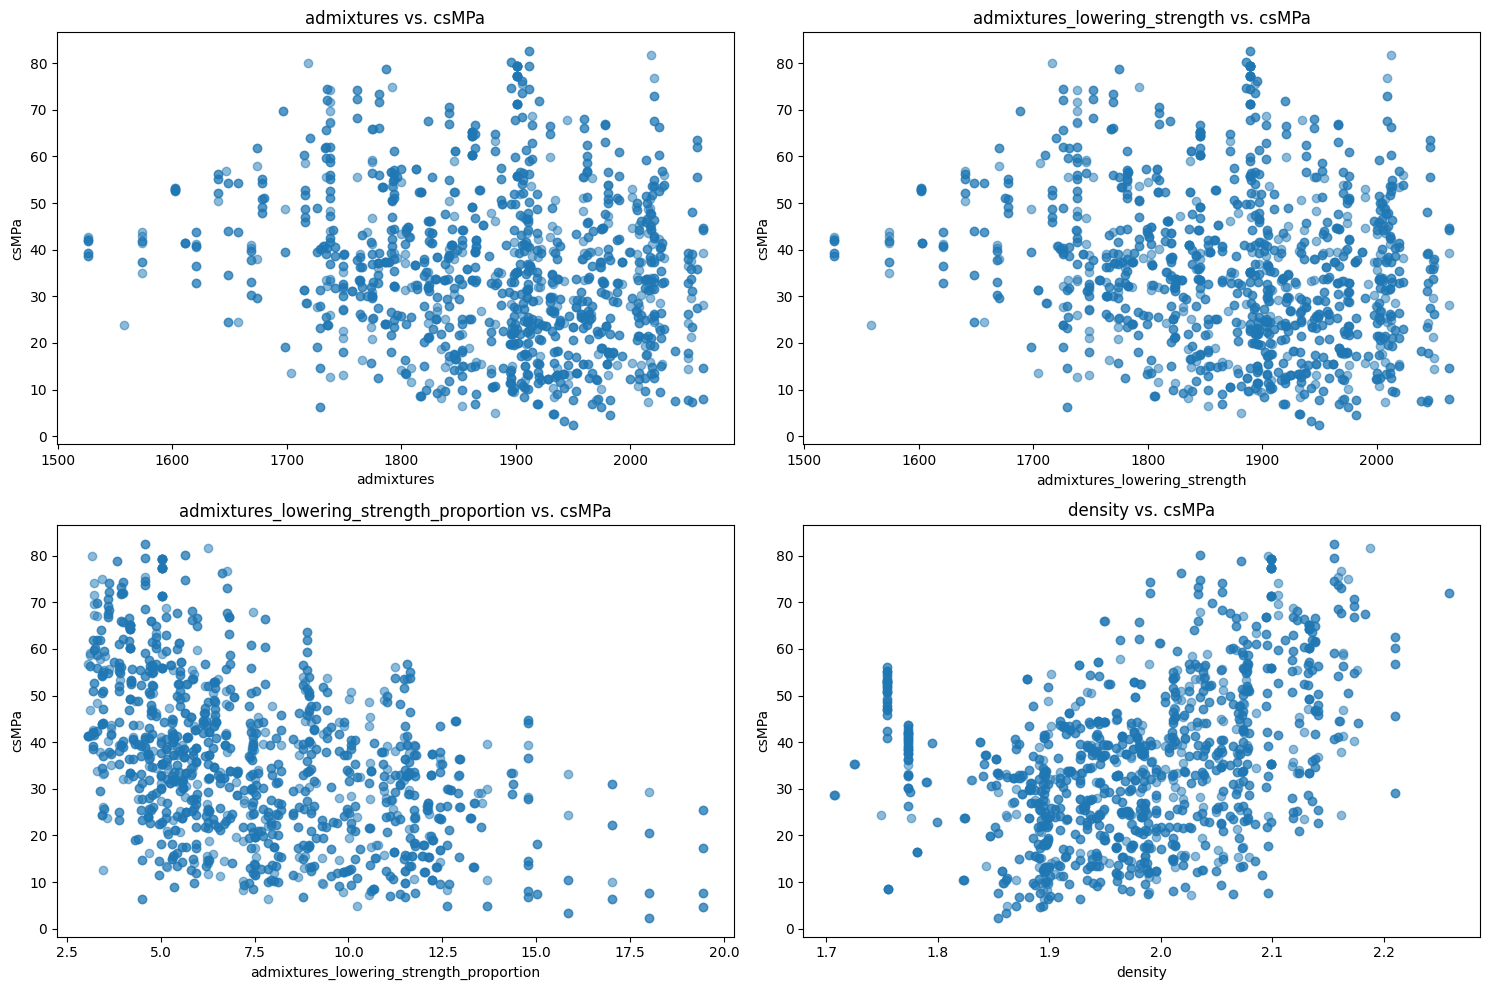

In [5]:
# Set up subplots
feature_columns = ["admixtures", "admixtures_lowering_strength", "admixtures_lowering_strength_proportion", "density"]
num_features = len(feature_columns)
num_cols = 2 # Number of columns in the subplot grid
num_rows = (num_features - 1) // num_cols + 1  # Calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Plot each feature against 'csMPa'
for i, feature in enumerate(feature_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.scatter(train_df[feature], train_df['csMPa'], alpha=0.5)
    ax.set_title(f'{feature} vs. csMPa')
    ax.set_xlabel(feature)
    ax.set_ylabel('csMPa')

# Remove any unused subplots
for i in range(num_features, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

In [6]:
TARGET = 'csMPa'

merged_df = train_df
train_data = merged_df.sample(frac=0.8, random_state=42)
val_data = merged_df.drop(train_data.index)

# training a model
ag = TabularPredictor(label=TARGET).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20240526_121925"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240526_121925"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.0
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.3.0: Thu Dec 21 02:29:41 PST 

[1000]	valid_set's rmse: 2.71909
[2000]	valid_set's rmse: 2.53688
[3000]	valid_set's rmse: 2.46955
[4000]	valid_set's rmse: 2.44592
[5000]	valid_set's rmse: 2.41544
[6000]	valid_set's rmse: 2.40813
[7000]	valid_set's rmse: 2.4054
[8000]	valid_set's rmse: 2.40139
[9000]	valid_set's rmse: 2.40114
[10000]	valid_set's rmse: 2.39945


	-2.3974	 = Validation score   (-root_mean_squared_error)
	14.8s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 2.42878
[2000]	valid_set's rmse: 2.40551
[3000]	valid_set's rmse: 2.40313


	-2.4015	 = Validation score   (-root_mean_squared_error)
	6.36s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-2.9118	 = Validation score   (-root_mean_squared_error)
	4.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: CatBoost ...
	-2.2546	 = Validation score   (-root_mean_squared_error)
	14.71s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-3.2687	 = Validation score   (-root_mean_squared_error)
	0.14s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-4.51	 = Validation score   (-root_mean_squared_error)
	0.84s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: XGBoost ...
	-2.5554	 = Validation score   (-root_mean_squared_error)
	0.71s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-3.6973	 = Validation score   (-root_mean_squared_error)
	2.74s	 = Training   runtime
	0.0s	 = Validation runtime
F

[1000]	valid_set's rmse: 2.9362
[2000]	valid_set's rmse: 2.93571


	-2.9351	 = Validation score   (-root_mean_squared_error)
	17.06s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'CatBoost': 0.471, 'LightGBMXT': 0.294, 'RandomForestMSE': 0.176, 'LightGBMLarge': 0.059}
	-2.1822	 = Validation score   (-root_mean_squared_error)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 65.14s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20240526_121925")


In [7]:
# validation data
X_val = val_data.drop(columns=['csMPa'])
y_val = val_data['csMPa']
y_pred_ag = ag.predict(X_val)

In [8]:
def calculate_error_metrics(X_val: pd.DataFrame, y_val: pd.DataFrame, y_pred) -> pd.DataFrame:
    k = X_val.shape[1]
    n = len(X_val)

    MSE = mean_squared_error(y_val, y_pred, squared=True)
    #RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    RMSE = mean_squared_error(y_val, y_pred, squared=False)
    MAE = mean_absolute_error(y_val, y_pred)
    MAPE = np.mean(np.abs( (y_val - y_pred) / y_val))*100
    r2 = r2_score(y_val, y_pred)
    adj_r2 = 1-(1-r2) * (n-1)/(n-k-1)

    results = [MSE, RMSE, MAE, MAPE, r2, adj_r2]
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'r2', 'adj_r2']

    table_results = pd.DataFrame({'Metric': metrics, 'Score': results})
    return table_results
    
calculate_error_metrics(X_val, y_val, y_pred_ag)

/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/demo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Metric,Score
0,MSE,11.871593
1,RMSE,3.445518
2,MAE,1.551349
3,MAPE,5.413197
4,r2,0.959917
5,adj_r2,0.958490


In [9]:
# get final predictions and write to a file

model=ag
model_name="autogluon_more_data_additional_features"

# predict
y_pred = model.predict(test_df.drop(columns=['Row ID']))

# create output dataset
df_y_out = test_df[['Row ID']].copy()
df_y_out['csMPa'] = y_pred

# write to a file
df_y_out.to_csv(f'submission.csv', index=False)